In [1]:
import jax.numpy as jnp
from jax import random
from melvin.laplace import LaplaceApproximation
import jax
import matplotlib.pylab as plt
from functools import partial

jax.config.update("jax_enable_x64", True)

In [30]:
SEED = random.PRNGKey(123068)
N_ROWS = 200
N_PARAMS = 10
NOISE_AMPLITUDE = 2.0

In [31]:
SEED, _seed = random.split(SEED)
true_params = jax.random.normal(key=_seed, shape=(N_PARAMS,))
print(f"True parameters\n{true_params}")

SEED, _seed = random.split(SEED)
X = jax.random.normal(key=_seed, shape=(N_ROWS, N_PARAMS))
print(f"\nFirst 2 rows of data\n{X[:2,:]}")

SEED, _seed = random.split(SEED)
eps = NOISE_AMPLITUDE*jax.random.normal(key=_seed, shape=(N_ROWS,))
y = X @ true_params + eps
print(f"\nFirst 2 labels\n{y[:2]}")

True parameters
[ 2.36672409 -0.16807065  1.70332258 -0.64576907 -1.04568325  0.18535912
 -0.64097235 -0.32371337  0.27884898  0.42407802]

First 2 rows of data
[[-0.75950763  0.04695944 -0.02698257  0.74150811  0.27780349 -0.29848826
   1.82491359  0.43483668  0.11394319  0.12632439]
 [ 0.73752459  0.62186619 -1.29744176 -0.43197679  2.44279596  2.61471583
  -0.77380687 -0.25282532  1.43341798  0.55680473]]

First 2 labels
[-3.69059232  0.85072318]


In [32]:
def model_fn(params, X, fixed_params):
    return X @ params

def loss_fn(y, y_pred, params, fixed_params):
    return jnp.mean((y - y_pred)**2)

SEED, _seed = random.split(SEED)
initial_params = jax.random.normal(key=_seed, shape=(N_PARAMS,))

linear_model = BasicModel(
    name="Linear Model",
    model_fn=model_fn,
    loss_fn=loss_fn,
    initial_params=initial_params,
    fixed_params=jnp.array([]),
    optimizer=sgd,
    optimizer_kwargs={"step_size": 0.01}
)

linear_model.fit(n_steps=200, X=X, y=y)

NameError: name 'BasicModel' is not defined

In [33]:
class BayesianLinearModel(LaplaceApproximation):
    param_bounds = [(0.0, None)] + [(None, None)]*N_PARAMS

    def model(self, params, X):
        weights = params[1:]
        return X @ weights

    def posterior_log_prob(self, y, y_pred, params):
        noise = params[0]
        log_like = jax.scipy.stats.norm.logpdf(y, loc=y_pred, scale=noise)
        return jnp.sum(log_like)

SEED, _seed = random.split(SEED)
initial_weights = jax.random.normal(key=_seed, shape=(N_PARAMS,))
initial_noise = jnp.array([0.5])
initial_params = jnp.concatenate([initial_noise, initial_weights])

model = BayesianLinearModel(
    name="Bayesian Linear Model",
    initial_params=initial_params,
    fixed_params=None
)
model.fit(X=X, y=y)
print(model)

Laplace Approximation: Bayesian Linear Model
Fixed Parameters: None
Fit converged successfully
Fitted Parameters: 
	 1.9284545742555246 +/- 0.09642272862487236	 [Lower Bound = 0.0]
	 2.2905129808893414 +/- 0.1385539966542933
	 -0.24341077675892112 +/- 0.13973095674417502
	 1.5491716297427311 +/- 0.13694274301775516
	 -0.4498246972013979 +/- 0.1570942806999242
	 -0.7981271943526775 +/- 0.15395389600445164
	 0.06844898960381546 +/- 0.1253402224820456
	 -0.6732018156788705 +/- 0.13465251088433278
	 -0.3583555917064379 +/- 0.14015765290780294
	 0.03962605492531491 +/- 0.13991167354328993
	 0.29658813396522077 +/- 0.15083235332883393
Log Posterior Prob = -415.1314955085827


In [34]:
print(f"True parameters\n{true_params}")
print(f"\nFitted parameters\n{model.params[1:]}")

print(f"\nTrue noise\n{NOISE_AMPLITUDE}")
print(f"\nFitted noise\n{model.params[0]}")

True parameters
[ 2.36672409 -0.16807065  1.70332258 -0.64576907 -1.04568325  0.18535912
 -0.64097235 -0.32371337  0.27884898  0.42407802]

Fitted parameters
[ 2.29051298 -0.24341078  1.54917163 -0.4498247  -0.79812719  0.06844899
 -0.67320182 -0.35835559  0.03962605  0.29658813]

True noise
2.0

Fitted noise
1.9284545742555246


In [35]:
SEED, _seed = random.split(SEED,2)
samples = model.sample_params(prng_key = _seed, n_samples = 10000)

params_mean = jnp.mean(samples, axis=0)
params_low = jnp.percentile(samples, q=5, axis=0)
params_upp = jnp.percentile(samples, q=95, axis=0)

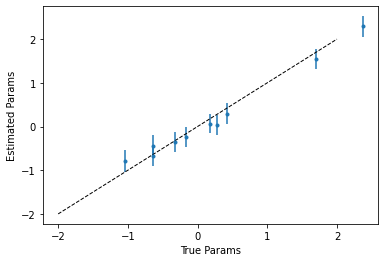

In [36]:
plt.errorbar(
    true_params, 
    model.params[1:], 
    yerr=(
        params_upp[1:] - params_mean[1:],
        params_mean[1:] - params_low[1:]
    ), 
    fmt="."
)
plt.plot(
    [-2, 2], [-2, 2], "k--", lw=1
)
plt.xlabel("True Params")
plt.ylabel("Estimated Params")
plt.show()